In [2]:
from scipy import misc
import imageio
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

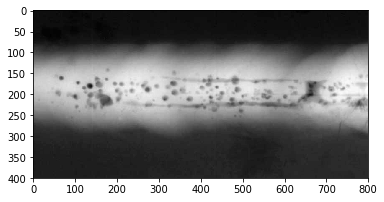

In [3]:
img = imageio.imread("si.jpg")
img = img.astype('int32')
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()
# # Convert color image to grayscale to help extraction of edges and plot it
# img_gray = np.dot(img[...,:3], [0.299, 0.587, 0.114])
# plt.imshow(img_gray, cmap = plt.get_cmap('gray'))
# plt.show()

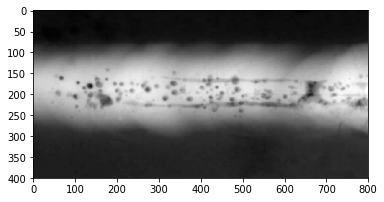

In [5]:
# Blur the grayscale image so that only important edges are extracted and the noisy ones ignored
img_guassian_filter = ndimage.gaussian_filter(img, sigma=1) # sigma is taken as 1.4
plt.imshow(img_guassian_filter, cmap = plt.get_cmap('gray'))
plt.show()

In [6]:
def SobelFilter(img, direction):
    if(direction == 'x'):
        Gx = np.array([[-1,0,+1], [-2,0,+2],  [-1,0,+1]])
        Res = ndimage.convolve(img, Gx)
        #Res = ndimage.convolve(img, Gx, mode='constant', cval=0.0)
    if(direction == 'y'):
        Gy = np.array([[-1,-2,-1], [0,0,0], [+1,+2,+1]])
        Res = ndimage.convolve(img, Gy)
        #Res = ndimage.convolve(img, Gy, mode='constant', cval=0.0)
    
    return Res
def Normalize(img):
    #img = np.multiply(img, 255 / np.max(img))
    img = img/np.max(img)
    return img

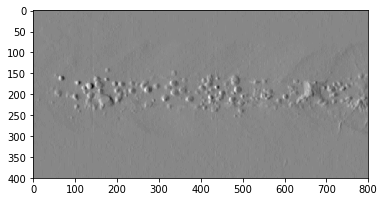

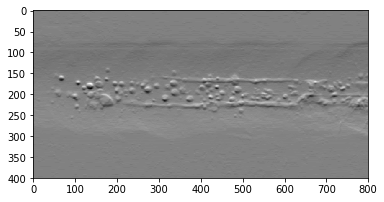

(400, 800)

In [7]:
gx = SobelFilter(img_guassian_filter, 'x')
gx = Normalize(gx)
plt.imshow(gx, cmap = plt.get_cmap('gray'))
plt.show()
gy = SobelFilter(img_guassian_filter, 'y')
gy = Normalize(gy)
plt.imshow(gy, cmap = plt.get_cmap('gray'))
plt.show()
type(gx)
gx.shape

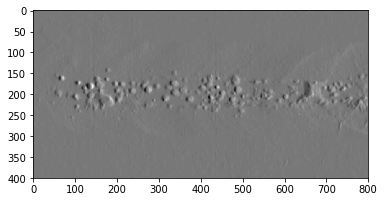

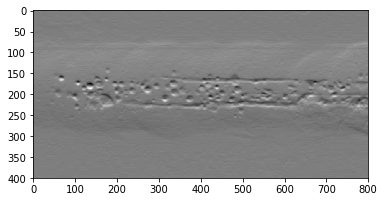

(400, 800)

In [8]:
dx = ndimage.sobel(img_guassian_filter, axis=1) # horizontal derivative
plt.imshow(dx, cmap = plt.get_cmap('gray'))
plt.show()
dy = ndimage.sobel(img_guassian_filter, axis=0) # vertical derivative
plt.imshow(dy, cmap = plt.get_cmap('gray'))
plt.show()
type(dx)
dx.shape
dy.shape

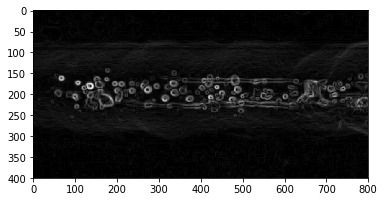

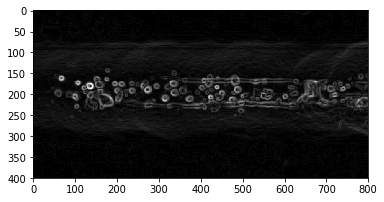

In [9]:
Mag = np.hypot(gx,gy)
Mag.shape
plt.imshow(Mag, cmap = plt.get_cmap('gray'))
plt.show()
mag = np.hypot(dx,dy)
mag.shape
plt.imshow(mag, cmap = plt.get_cmap('gray'))
plt.show()

In [10]:
Gradient = np.degrees(np.arctan2(gy,gx))
gradient = np.degrees(np.arctan2(dy,dx))

In [11]:
def NonMaxSupWithInterpol(Gmag, Grad, Gx, Gy):
    NMS = np.zeros(Gmag.shape)
    
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= 0 and Grad[i,j] <= 45) or (Grad[i,j] < -135 and Grad[i,j] >= -180)):
                yBot = np.array([Gmag[i,j+1], Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i,j-1], Gmag[i-1,j-1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                      NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 45 and Grad[i,j] <= 90) or (Grad[i,j] < -90 and Grad[i,j] >= -135)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j-1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] =Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 90 and Grad[i,j] <= 135) or (Grad[i,j] < -45 and Grad[i,j] >= -90)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] =Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 135 and Grad[i,j] <= 180) or (Grad[i,j] < 0 and Grad[i,j] >= -45)):
                yBot = np.array([Gmag[i,j-1] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i,j+1] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] =Gmag[i,j]
                else:
                    NMS[i,j] = 0
    
    return NMS

In [12]:
# This is also non-maxima suppression but without interpolation i.e. the pixel closest to the gradient direction is used as the estimate
def NonMaxSupWithoutInterpol(Gmag, Grad):
    NMS = np.zeros(Gmag.shape)
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= -22.5 and Grad[i,j] <= 22.5) or (Grad[i,j] <= -157.5 and Grad[i,j] >= 157.5)):
                if((Gmag[i,j] > Gmag[i,j+1]) and (Gmag[i,j] > Gmag[i,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 22.5 and Grad[i,j] <= 67.5) or (Grad[i,j] <= -112.5 and Grad[i,j] >= -157.5)):
                if((Gmag[i,j] > Gmag[i+1,j+1]) and (Gmag[i,j] > Gmag[i-1,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 67.5 and Grad[i,j] <= 112.5) or (Grad[i,j] <= -67.5 and Grad[i,j] >= -112.5)):
                if((Gmag[i,j] > Gmag[i+1,j]) and (Gmag[i,j] > Gmag[i-1,j])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 112.5 and Grad[i,j] <= 157.5) or (Grad[i,j] <= -22.5 and Grad[i,j] >= -67.5)):
                if((Gmag[i,j] > Gmag[i+1,j-1]) and (Gmag[i,j] > Gmag[i-1,j+1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0

    return NMS

C:\Users\Blotzmann\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


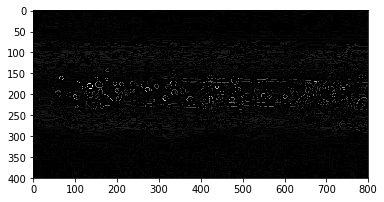

In [13]:
NMS = NonMaxSupWithInterpol(mag, gradient, dx, dy)
NMS = Normalize(NMS)
plt.imshow(NMS, cmap = plt.get_cmap('gray'))
plt.show()

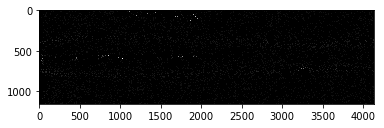

In [202]:
WINMS = NonMaxSupWithoutInterpol(Mag,Gradient)
WINMS = Normalize(WINMS)
plt.imshow(WINMS, cmap = plt.get_cmap('gray'))
plt.show()

C:\Users\Blotzmann\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


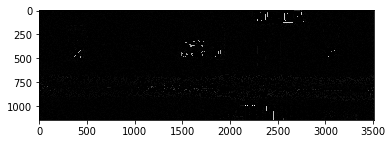

In [73]:
nms = NonMaxSupWithInterpol(mag, gradient, dx, dy)
nms = Normalize(nms)
plt.imshow(nms, cmap = plt.get_cmap('gray'))
plt.show()

In [14]:
# Double threshold Hysterisis
# Note that I have used a very slow iterative approach for ease of understanding, a faster implementation using recursion can be done instead
# This recursive approach would recurse through every strong edge and find all connected weak edges
def DoThreshHyst(img):
    highThresholdRatio =0.32
    lowThresholdRatio = 0.30
    GSup = np.copy(img)
    h = int(GSup.shape[0])
    w = int(GSup.shape[1])
    highThreshold = np.max(GSup) * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio    
    x = 0.1
    oldx=0
    
    # The while loop is used so that the loop will keep executing till the number of strong edges do not change, i.e all weak edges connected to strong edges have been found
#     while(oldx != x):
#         oldx = x
    for i in range(1,h-1):
        for j in range(1,w-1):
            if(GSup[i,j] > highThreshold):
                GSup[i,j] = 1
            elif(GSup[i,j] < lowThreshold):
                GSup[i,j] = 0
            else:
                if((GSup[i-1,j-1] > highThreshold) or 
                    (GSup[i-1,j] > highThreshold) or
                    (GSup[i-1,j+1] > highThreshold) or
                    (GSup[i,j-1] > highThreshold) or
                    (GSup[i,j+1] > highThreshold) or
                    (GSup[i+1,j-1] > highThreshold) or
                    (GSup[i+1,j] > highThreshold) or
                    (GSup[i+1,j+1] > highThreshold)):
                    GSup[i,j] = 1
#         x = np.sum(GSup == 1)
    
    GSup = (GSup == 1) * GSup # This is done to remove/clean all the weak edges which are not connected to strong edges
    
    return GSup

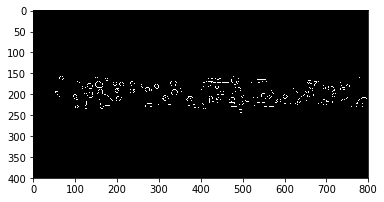

In [15]:
Final_Image = DoThreshHyst(NMS)
plt.imshow(Final_Image, cmap = plt.get_cmap('gray'))
plt.show()

In [16]:
imageio.imwrite('img_guassian_filter.jpg', img_guassian_filter)
imageio.imwrite('gx.jpg', gx)
imageio.imwrite('gy.jpg', gy)
imageio.imwrite('Mag.jpg', mag)
imageio.imwrite('NMS.jpg', NMS)
imageio.imwrite('Final_Image.jpg', Final_Image)



Lossy conversion from int32 to uint8. Range [25, 183]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.1176470588235294, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0192307692307692, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 166.23477373883]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [17]:
import cv2

In [18]:
img = cv2.imread('Final_Image.jpg', 0) 
  
kernel = np.ones((5,5), np.uint8) 
 
img_dilation = cv2.dilate(img, kernel, iterations=1) 
img_erosion = cv2.erode(img_dilation, kernel, iterations=1) 
img_dilation_mag = cv2.dilate(Mag, kernel, iterations=1) 
img_erosion_mag = cv2.erode(img_dilation_mag, kernel, iterations=1)
# img_erosion = cv2.erode(img_erosion, kernel, iterations=1) 

In [19]:
imageio.imwrite('img_dilation.jpg',img_dilation)
imageio.imwrite('img_erode.jpg',img_erosion)
imageio.imwrite('img_dilation_mag.jpg',img_dilation_mag)
imageio.imwrite('img_erode_mag.jpg',img_erosion_mag)

Lossy conversion from float64 to uint8. Range [0.0, 1.151425489624082]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1.151425489624082]. Convert image to uint8 prior to saving to suppress this warning.
